In [43]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

df = pd.read_csv('/Users/varnika/Desktop/harvard/all_var_int.csv')
pd.set_option('display.max_columns', None)

/var/folders/gw/xg9wcgln7x1f2k7qpz6vkm_c0000gn/T/ipykernel_41826/1522025319.py:7: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/varnika/Desktop/harvard/all_var_int.csv')


In [54]:
if 'min_elev' not in df.columns:
    if 'elev_mean' in df.columns:
        df['min_elev'] = 1 - (df['elev_mean'] / df['elev_mean'].max())
    else:
        print("Warning: 'elev_mean' not found. Removing 'min_elev' from variables.")

# 2. Define the tsunami_expo_vars WITHOUT duplicates

tsunami_expo_vars = [
    "min_elev",    # or remove if not actually in the CSV
    "storm_freq",
    "flood_freq" ] 

In [57]:
import pandas as pd

id_cols = ["state_code", "district_code", "block_code", "FID_Key"]
tsunami_expo_cols = id_cols + tsunami_expo_vars

tsunami_expo_df = df[tsunami_expo_cols].copy()

# Check for missing
print(tsunami_expo_df.isna().sum())


state_code       0
district_code    0
block_code       0
FID_Key          0
min_elev         0
storm_freq       0
flood_freq       0
dtype: int64


In [58]:
from sklearn.preprocessing import RobustScaler
Rscaler = RobustScaler()
features_only = tsunami_expo_df[tsunami_expo_vars].astype(float).values
features_scaled = Rscaler.fit_transform(features_only)

# 7. Create scaled columns
expo_scaled = pd.DataFrame(features_scaled,
                           columns=tsunami_expo_vars,
                           index=tsunami_expo_df.index)

for col in tsunami_expo_vars:
    tsunami_expo_df[col + "_scaled"] = expo_scaled[col]

In [59]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA()
expo_pca_vars = [c for c in tsunami_expo_df.columns if c.endswith("_scaled")]
X_expo = tsunami_expo_df[expo_pca_vars].astype(float)
pca.fit(X_expo)

# Summarize variance
pcaSummary_tsunami_expo = pd.DataFrame({
    '% variance': pca.explained_variance_ratio_,
    'Cumulative %': np.cumsum(pca.explained_variance_ratio_)
})
print("\nPCA Variance Summary (Tsunami Exposure):")
print(pcaSummary_tsunami_expo.round(3))



PCA Variance Summary (Tsunami Exposure):
   % variance  Cumulative %
0       0.736         0.736
1       0.212         0.948
2       0.052         1.000


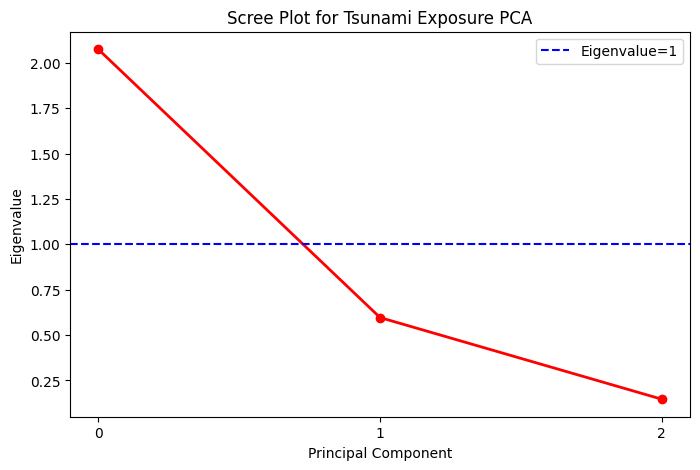

In [60]:
import matplotlib.pyplot as plt

eigenvalues = pca.explained_variance_
xvals = np.arange(len(eigenvalues))

plt.figure(figsize=(8,5))
plt.plot(xvals, eigenvalues, 'ro-', linewidth=2)
plt.title("Scree Plot for Tsunami Exposure PCA")
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue")
plt.axhline(y=1, color='b', linestyle='--', label="Eigenvalue=1")
plt.xticks(xvals)
plt.legend()
plt.show()


In [61]:
n_components = 1  # or 3, based on your scree plot
pca_n = PCA(n_components=n_components)
X_expo_pca = pca_n.fit_transform(X_expo)

pca_weights = pcaSummary_tsunami_expo['% variance'][:n_components]

# Add the principal components to the DataFrame
for i in range(n_components):
    tsunami_expo_df[f"TsunExp_PC{i+1}"] = X_expo_pca[:, i]

# Weighted sum => "Tsunami_Exposure_Index"
tsunami_expo_df["Tsunami_Exposure_Index"] = 0
for i in range(n_components):
    tsunami_expo_df["Tsunami_Exposure_Index"] += (
        pca_weights.iloc[i] * tsunami_expo_df[f"TsunExp_PC{i+1}"]
    )

print("\nHead of final DataFrame with Tsunami Exposure Index:")
print(tsunami_expo_df[["block_code", "Tsunami_Exposure_Index"]].head())
print("\nStats Summary of Tsunami_Exposure_Index:")
print(tsunami_expo_df["Tsunami_Exposure_Index"].describe())


Head of final DataFrame with Tsunami Exposure Index:
   block_code  Tsunami_Exposure_Index
0        6498               -0.203304
1        6492               -0.294710
2        4689               -0.041013
3        4690                0.140736
4        4692                0.211788

Stats Summary of Tsunami_Exposure_Index:
count    5815.000000
mean        0.000000
std         1.060669
min        -0.914096
25%        -0.672649
50%        -0.233799
75%         0.296272
max         9.797066
Name: Tsunami_Exposure_Index, dtype: float64


In [62]:
loadings_expo = pd.DataFrame(
    pca_n.components_.T,
    index=expo_pca_vars,
    columns=[f"PC{i+1}" for i in range(n_components)]
)
print(loadings_expo)


                        PC1
min_elev_scaled   -0.959358
storm_freq_scaled -0.170333
flood_freq_scaled -0.224985
